# Visualization

Psi4 can produce cube files containing various properties.  Here's how to visualize the information in Jupyter.

In [111]:
%matplotlib notebook

import numpy as np
import psi4
from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, interactive, widgets

In [112]:
psi4.set_memory(int(5e8))
numpy_memory = 2

psi4.core.set_output_file('output.dat', False)

mol = psi4.geometry("""
O
H 1 1.1
H 1 1.1 2 104
""")

# Set computation options
psi4.set_options({'basis': 'cc-pvdz',
                  'e_convergence': 1e-8})

E,wfn = psi4.energy('scf', return_wfn=True)

In [113]:
class Visualizer:
    def parse_cube(self, filename):
        """ Parses a cube file, returning a dict of the information contained.
            The cubefile itself is stored in a numpy array. """
        with open(filename) as fp:
            results = {}

            # skip over the title
            fp.readline()
            fp.readline()

            origin = fp.readline().split()
            natoms = int(origin[0])
            results['minx'] = minx = float(origin[1])
            results['miny'] = miny = float(origin[2])
            results['minz'] = minz = float(origin[3])

            infox = fp.readline().split()
            numx = int(infox[0])
            incx = float(infox[1])
            results['incx'] = incx
            results['numx'] = numx
            results['maxx'] = minx + incx * numx

            infoy = fp.readline().split()
            numy = int(infoy[0])
            incy = float(infoy[2])
            results['incy'] = incy
            results['numy'] = numy
            results['maxy'] = miny + incy * numy

            infoz = fp.readline().split()
            numz = int(infoz[0])
            incz = float(infoz[3])
            results['incz'] = incz
            results['numz'] = numz
            results['maxz'] = minz + incz * numz

            atnums = []
            coords = []
            for atom in range(natoms):
                coordinfo = fp.readline().split()
                atnums.append(int(coordinfo[0]))
                coords.append(list(map(float, coordinfo[2:])))
            results['atom_numbers'] = np.array(atnums)
            results['atom_coords'] = np.array(coords)

            data = np.array([ float(entry) for line in fp for entry in line.split() ])
            if len(data) != numx*numy*numz:
                raise Exception("Amount of parsed data is inconsistent with header in Cube file!")
            results['data'] = data.reshape((numx,numy,numz))

            return results

    def run_cubeprop(self):
        import tempfile, shutil
        tmpdir = tempfile.mkdtemp()
        psi4.set_options({'cubeprop_filepath' : tmpdir,
                          'cubic_grid_spacing' : [self.spacing]*3})
        psi4.cubeprop(self.wfn)
        data = self.parse_cube(tmpdir + "/" + self.cubefile)
        shutil.rmtree(tmpdir)
        return data

    def process_cubefile(self):
        import re
        orbitalre = re.compile(r'Psi_([ab])_(\d+)_.*.cube')
        matchobj = orbitalre.match(self.cubefile)
        if matchobj:
            orbnum = int(matchobj.group(2))
            if matchobj.group(1) == 'b': orbnum = -orbnum
            psi4.set_options({'cubeprop_tasks' : ['orbitals']})
            psi4.set_options({'cubeprop_orbitals' : [orbnum]})
        elif(self.cubefile.startswith("D")):
            psi4.set_options({'cubeprop_tasks' : ['density']})
        else:
            raise("Unrecognized cube file type.")
        return self.run_cubeprop()
    
    def plot(self, isovalue, grid_spacing, cubefile, surface_transparency, 
             mesh_transparency, show_atoms):
        if not self.data \
           or grid_spacing != self.spacing \
           or cubefile != self.cubefile:
            # This is quite expensive, so only should be updated when necessary
            self.spacing = grid_spacing
            self.cubefile = cubefile
            self.data = self.process_cubefile()
            
        self.ax.cla()            
        # the positive plot
        vertices, faces, normals, values = \
             measure.marching_cubes_lewiner(self.data['data'], level=isovalue, 
                                            spacing=(self.data['incx'],
                                                     self.data['incy'],
                                                     self.data['incz']))
        self.ax.plot_trisurf(vertices[:, 0], vertices[:,1], faces, vertices[:, 2], 
                             color=(0, 0, 1, surface_transparency/100),
                             edgecolors=(0,0,0,mesh_transparency/100), lw=0.02)
        # the negative plot; not really a great way to identify a non-density plot
        if not self.cubefile.startswith("D"):
            vertices, faces, normals, values = \
                 measure.marching_cubes_lewiner(-self.data['data'], level=isovalue, 
                                                spacing=(self.data['incx'],
                                                         self.data['incy'],
                                                         self.data['incz']))
            self.ax.plot_trisurf(vertices[:, 0], vertices[:,1], faces, vertices[:, 2], 
                                 color=(1, 0, 0, surface_transparency/100),
                                 edgecolors=(0,0,0,mesh_transparency/100), lw=0.02)

        self.ax.set_xticks([])
        self.ax.set_yticks([])
        self.ax.set_zticks([])

        if show_atoms:
            xs = self.data['atom_coords'][:,0]-self.data['minx']
            ys = self.data['atom_coords'][:,1]-self.data['miny']
            zs = self.data['atom_coords'][:,2]-self.data['minz']
            self.ax.scatter(xs, ys, zs, c='g', s=15.0*self.data['atom_numbers'])

        plt.axis('off')
        plt.show()
        
    def __init__(self, wfn):
        self.data = None
        self.wfn = wfn
        self.spacing = 0.3
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(111, projection='3d')
        self.cubefile = "Dt.cube"
        
        orbsyms = [ irrep for irrep in range(wfn.nirrep()) for sym in range(wfn.nmopi()[irrep]) ]
        aevals = wfn.epsilon_a().nph
        bevals = wfn.epsilon_b().nph
        aorbenergies = [ aevals[irrep][orb] for irrep in range(wfn.nirrep()) for orb in range(wfn.nmopi()[irrep]) ]
        borbenergies = [ bevals[irrep][orb] for irrep in range(wfn.nirrep()) for orb in range(wfn.nmopi()[irrep]) ]
        aevals = sorted(zip(aorbenergies, orbsyms))
        bevals = sorted(zip(borbenergies, orbsyms))
        def process_evals(label, nocc, evals):
            irrep_labels = wfn.molecule().irrep_labels()
            symcount = [ 1 for irrep in range(wfn.nirrep()) ]
            orbitaldict = {}
            for orbital,evaltuple in enumerate(evals):
                evalue = evaltuple[0]
                irrep = evaltuple[1]
                symlabel = irrep_labels[irrep]
                filename = 'Psi_{}_{}_{}-{}.cube'.format(label[0], orbital+1, symcount[irrep], symlabel)
                labelstr = '{} orbital {} ({}{}) {}{}, eigenvalue = {:.6}'
                if orbital < nocc: 
                    orblabel = labelstr.format(
                        label, orbital+1, symcount[irrep], symlabel, "HOMO", str(orbital-nocc), evalue)
                elif orbital == nocc:
                    orblabel = labelstr.format(
                        label, orbital+1, symcount[irrep], symlabel, "HOMO", "", evalue)
                elif orbital == nocc+1:
                    orblabel = labelstr.format(
                        label, orbital+1, symcount[irrep], symlabel, "LUMO", "", evalue)
                else:
                    orblabel = labelstr.format(
                        label, orbital+1, symcount[irrep], symlabel, "LUMO", "+"+str(orbital-nocc-1), evalue)
                symcount[irrep] += 1
                orbitaldict[orblabel] = filename
            return orbitaldict
        plotdict = {"total density" : "Dt.cube",
                    "alpha density" : "Da.cube",
                    "beta density" : "Db.cube",
                    "spin density" : "Ds.cube"}
        plotdict.update(process_evals('alpha', wfn.nalpha(), aevals))
        plotdict.update(process_evals('beta', wfn.nbeta(), bevals))
        interact(self.plot,
                 show_atoms=widgets.Checkbox(value=True),
                 isovalue=widgets.FloatSlider(min=0,max=0.1,step=.01,value=0.01,
                                              description="Isovalue: "),
                 mesh_transparency=widgets.FloatSlider(min=0.0,max=100.0,step=10.0,value=40.0,
                                                      description="Mesh Opacity: "),
                 surface_transparency=widgets.FloatSlider(min=0.0,max=100.0,step=10.0,value=40.0,
                                                         description="Surface Opacity: "),
                 grid_spacing=widgets.FloatSlider(min=0.05,max=0.5,step=.05,value=self.spacing,
                                                 description="Grid spacing: "),
                 cubefile=widgets.Dropdown(options=plotdict, value=self.cubefile,
                                          description="Plot type: "))

<IPython.core.display.Javascript object>


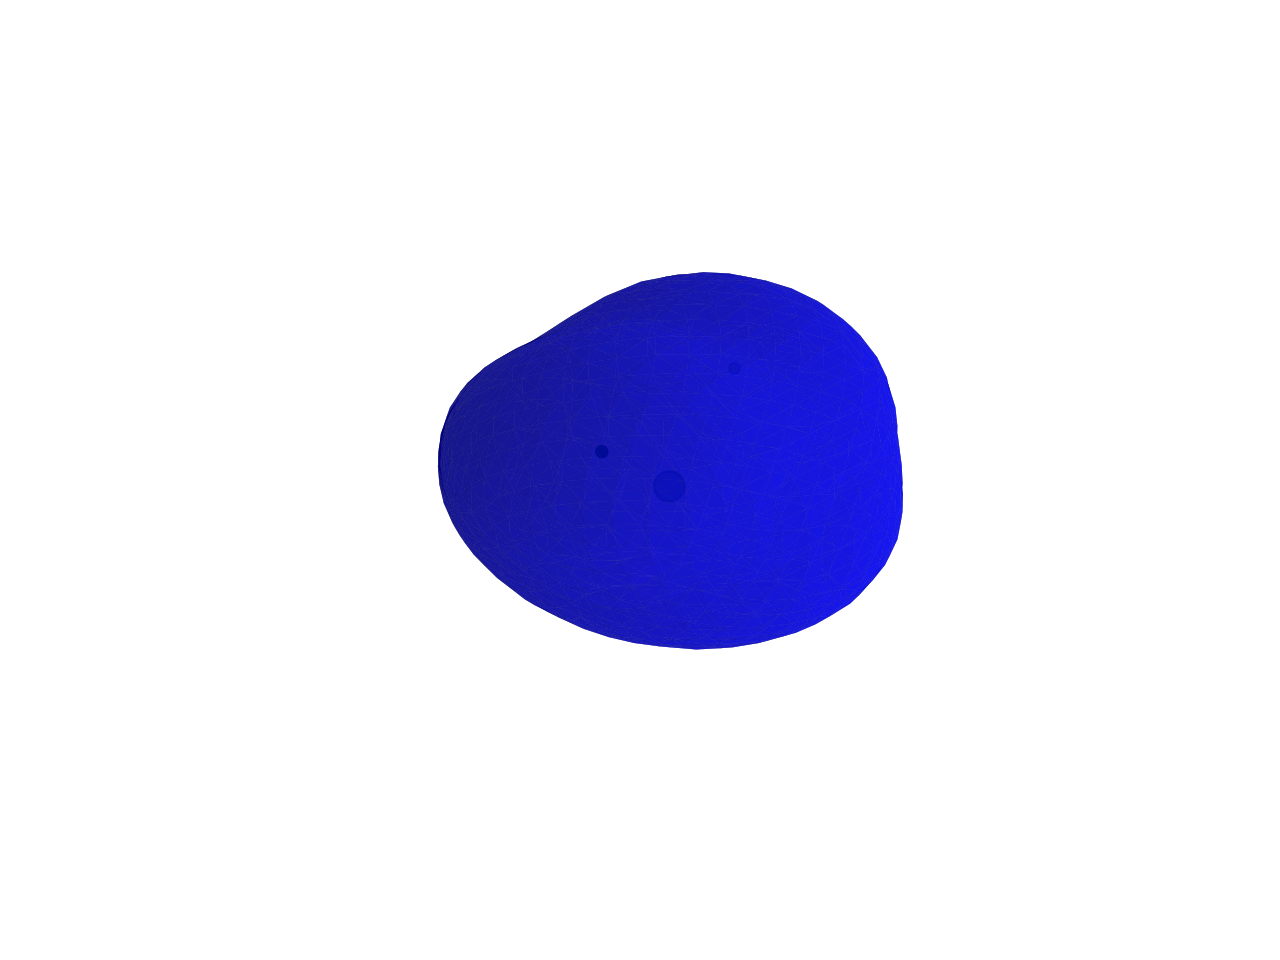

A Jupyter Widget

In [114]:
Visualizer(wfn)